Finding the optimal threshold of distance for determining the mode of transport of the employees

In [2]:

import pandas as pd
from math import cos, asin, sqrt, sin, atan2

import geopy.distance
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from collections import Counter

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

In [128]:
hubs = pd.read_csv('us_salesforce_hubs.csv')
hubs = hubs.drop(hubs.columns[[0]], axis=1)

emps = pd.read_excel('Fake Flight Prices from Zips.xlsx')
emps = emps.drop(emps.columns[[0, 1]], axis=1)

drive = pd.read_excel('driving calculations.xlsx')
drive = drive.drop(drive.columns[[0]], axis=1)
emps

,postal_code,state,latitude,longitude,Closest Airport,Closest LATITUDE,Closest LONGITUDE,Uber house to airport,Flight to Atlanta,Flight to Bellevue,Flight to Chicago,Flight to Dallas,Flight to Denver,Flight to Indianapolis,Flight to New York,Flight to San Francisco,Flight to Seattle,Flight to The Ranch
0,01503-1716,Massachusetts,42.373140,-71.621630,ORH,42.267339,-71.875709,33.5,265.919140,566.077769,256.260525,429.998243,244.064959,131.461139,605.952859,566.078477,605.874673,389.169126
1,01545-1666,Massachusetts,42.324840,-71.699530,ORH,42.267339,-71.875709,27.0,264.937474,565.681310,255.573951,429.305368,243.256194,130.475049,605.328338,565.682019,605.233545,388.257860
2,01748-2814,Massachusetts,42.235910,-71.492080,ORH,42.267339,-71.875709,54.5,265.959533,568.005194,257.703896,431.424078,245.169979,131.280433,607.526940,568.005903,607.414804,389.836636
3,01803-2318,Massachusetts,42.516210,-71.214060,BOS,42.364348,-71.005179,51.5,270.242232,568.788575,260.009234,433.755466,248.169835,135.682441,609.482197,568.789283,609.459598,393.498331
4,01803-3742,Massachusetts,42.502190,-71.192380,BOS,42.364348,-71.005179,43.0,270.314474,569.058096,260.235169,433.981362,248.361367,135.728557,609.722684,569.058804,609.696940,393.643969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,99354,Washington,46.297470,-119.287530,PSC,46.264680,-119.119029,43.0,478.559529,131.306594,398.052696,261.499833,423.632438,531.278999,215.700656,131.307183,223.921365,386.769453
6218,99504,Alaska,61.218070,-149.729005,ANC,61.174320,-149.996186,34.0,737.802513,372.244420,633.872571,553.849431,664.582123,737.331748,479.985706,372.243991,490.250383,678.338907
6219,99516,Alaska,61.105915,-149.833985,ANC,61.174320,-149.996186,28.5,738.415380,372.135698,634.586998,554.043873,665.285605,738.281220,479.513836,372.135265,489.776220,678.594615
6220,99577,Alaska,61.323155,-149.568300,ANC,61.174320,-149.996186,54.5,736.842570,372.014641,632.817812,553.302212,663.537344,736.062996,480.143947,372.014216,490.410942,677.728499


In [129]:
emps['lat_long'] = emps[['latitude', 'longitude']].apply(tuple, axis=1)

hubs['lat_long'] = hubs[['latitude', 'longitude']].apply(tuple, axis=1)


atlanta_coord = hubs.loc[hubs['salesforce_hub'] == "Atlanta", 'lat_long']
bellevue_coord = hubs.loc[hubs['salesforce_hub'] == "Bellevue", 'lat_long']
chicago_coord = hubs.loc[hubs['salesforce_hub'] == "Chicago", 'lat_long']
dallas_coord = hubs.loc[hubs['salesforce_hub'] == "Dallas", 'lat_long']
denver_coord = hubs.loc[hubs['salesforce_hub'] == "Denver", 'lat_long']
indianapolis_coord = hubs.loc[hubs['salesforce_hub'] == "Indianapolis", 'lat_long']
newyork_coord = hubs.loc[hubs['salesforce_hub'] == "New York", 'lat_long']
sanfrancisco_coord = hubs.loc[hubs['salesforce_hub'] == "San Francisco", 'lat_long']
seattle_coord = hubs.loc[hubs['salesforce_hub'] == "Seattle", 'lat_long']
theranch_coord = hubs.loc[hubs['salesforce_hub'] == "The Ranch", 'lat_long']


coords_list = [atlanta_coord, bellevue_coord, chicago_coord, dallas_coord, denver_coord, indianapolis_coord, newyork_coord, sanfrancisco_coord, seattle_coord, theranch_coord]

hub_cities = ["Atlanta","Bellevue","Chicago","Dallas","Denver","Indianapolis","New York","San Francisco","Seattle","The Ranch"]


ind = 0
for z in coords_list:
    dist_col = []
    for i in emps["lat_long"]:
        dist = geodesic(z, i).miles
        dist_col.append(dist) 
       # print(dist_col)
    emps[hub_cities[ind]] = dist_col
    ind = ind + 1


emps


,postal_code,state,latitude,longitude,Closest Airport,Closest LATITUDE,Closest LONGITUDE,Uber house to airport,Flight to Atlanta,Flight to Bellevue,...,Atlanta,Bellevue,Chicago,Dallas,Denver,Indianapolis,New York,San Francisco,Seattle,The Ranch
0,01503-1716,Massachusetts,42.373140,-71.621630,ORH,42.267339,-71.875709,33.5,265.919140,566.077769,...,873.977296,2459.718228,824.601586,1524.330364,1741.221997,760.114271,165.731031,2669.442717,2459.721967,2668.922600
1,01545-1666,Massachusetts,42.324840,-71.699530,ORH,42.267339,-71.875709,27.0,264.937474,565.681310,...,868.804903,2457.618584,820.977115,1519.528479,1737.565959,755.849330,160.535224,2666.146735,2457.622325,2665.539503
2,01748-2814,Massachusetts,42.235910,-71.492080,ORH,42.267339,-71.875709,54.5,265.959533,568.005194,...,874.232967,2469.871440,832.214251,1527.881133,1748.746273,765.954600,164.821131,2677.746549,2469.875181,2677.048717
3,01803-2318,Massachusetts,42.516210,-71.214060,BOS,42.364348,-71.005179,51.5,270.242232,568.788575,...,896.777316,2474.047098,844.387402,1547.159952,1761.047817,781.767585,187.994954,2688.067473,2474.050833,2687.839148
4,01803-3742,Massachusetts,42.502190,-71.192380,BOS,42.364348,-71.005179,43.0,270.314474,569.058096,...,897.163336,2475.467671,845.579379,1547.931599,1762.239927,782.779370,188.243240,2689.336259,2475.471406,2689.091486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,99354,Washington,46.297470,-119.287530,PSC,46.264680,-119.119029,43.0,478.559529,131.306594,...,1996.152451,165.093336,1572.875444,1510.747774,851.413740,1707.593465,2275.812222,608.444951,165.096448,651.581906
6218,99504,Alaska,61.218070,-149.729005,ANC,61.174320,-149.996186,34.0,737.802513,372.244420,...,3363.533543,1436.220120,2817.179052,3048.634582,2393.520367,2978.814024,3363.169353,2002.259427,1436.217852,2056.221567
6219,99516,Alaska,61.105915,-149.833985,ANC,61.174320,-149.996186,28.5,738.415380,372.135698,...,3366.781391,1435.660801,2820.960033,3050.000448,2394.561638,2982.537838,3368.188866,1999.785195,1435.658514,2053.735335
6220,99577,Alaska,61.323155,-149.568300,ANC,61.174320,-149.996186,54.5,736.842570,372.014641,...,3358.452678,1434.991095,2811.600602,3045.395104,2390.615564,2973.287680,3356.463704,2003.076365,1434.988846,2057.050633


In [130]:
# Calculating closest office

odfe = emps.iloc[:, -10:]

closest = odfe.idxmin(axis="columns")
print(closest)

emps["closest_office"] = closest


# Cleaning 
emps.closest_office.unique()

emps['closest_office'] = emps['closest_office'].str.split('_').str[0]
print(emps['closest_office'])


emps.loc[emps["closest_office"] == "new", 'closest_office'] = "new york"
emps.loc[emps["closest_office"] == "the", 'closest_office'] = "the ranch"
emps.loc[emps["closest_office"] == "san", 'closest_office'] = "san francisco"

emps

0       New York
1       New York
2       New York
3       New York
4       New York
          ...   
6217    Bellevue
6218     Seattle
6219     Seattle
6220     Seattle
6221     Seattle
Length: 6222, dtype: object
0       New York
1       New York
2       New York
3       New York
4       New York
          ...   
6217    Bellevue
6218     Seattle
6219     Seattle
6220     Seattle
6221     Seattle
Name: closest_office, Length: 6222, dtype: object


,postal_code,state,latitude,longitude,Closest Airport,Closest LATITUDE,Closest LONGITUDE,Uber house to airport,Flight to Atlanta,Flight to Bellevue,...,Bellevue,Chicago,Dallas,Denver,Indianapolis,New York,San Francisco,Seattle,The Ranch,closest_office
0,01503-1716,Massachusetts,42.373140,-71.621630,ORH,42.267339,-71.875709,33.5,265.919140,566.077769,...,2459.718228,824.601586,1524.330364,1741.221997,760.114271,165.731031,2669.442717,2459.721967,2668.922600,New York
1,01545-1666,Massachusetts,42.324840,-71.699530,ORH,42.267339,-71.875709,27.0,264.937474,565.681310,...,2457.618584,820.977115,1519.528479,1737.565959,755.849330,160.535224,2666.146735,2457.622325,2665.539503,New York
2,01748-2814,Massachusetts,42.235910,-71.492080,ORH,42.267339,-71.875709,54.5,265.959533,568.005194,...,2469.871440,832.214251,1527.881133,1748.746273,765.954600,164.821131,2677.746549,2469.875181,2677.048717,New York
3,01803-2318,Massachusetts,42.516210,-71.214060,BOS,42.364348,-71.005179,51.5,270.242232,568.788575,...,2474.047098,844.387402,1547.159952,1761.047817,781.767585,187.994954,2688.067473,2474.050833,2687.839148,New York
4,01803-3742,Massachusetts,42.502190,-71.192380,BOS,42.364348,-71.005179,43.0,270.314474,569.058096,...,2475.467671,845.579379,1547.931599,1762.239927,782.779370,188.243240,2689.336259,2475.471406,2689.091486,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,99354,Washington,46.297470,-119.287530,PSC,46.264680,-119.119029,43.0,478.559529,131.306594,...,165.093336,1572.875444,1510.747774,851.413740,1707.593465,2275.812222,608.444951,165.096448,651.581906,Bellevue
6218,99504,Alaska,61.218070,-149.729005,ANC,61.174320,-149.996186,34.0,737.802513,372.244420,...,1436.220120,2817.179052,3048.634582,2393.520367,2978.814024,3363.169353,2002.259427,1436.217852,2056.221567,Seattle
6219,99516,Alaska,61.105915,-149.833985,ANC,61.174320,-149.996186,28.5,738.415380,372.135698,...,1435.660801,2820.960033,3050.000448,2394.561638,2982.537838,3368.188866,1999.785195,1435.658514,2053.735335,Seattle
6220,99577,Alaska,61.323155,-149.568300,ANC,61.174320,-149.996186,54.5,736.842570,372.014641,...,1434.991095,2811.600602,3045.395104,2390.615564,2973.287680,3356.463704,2003.076365,1434.988846,2057.050633,Seattle


In [131]:
# Test
thresh = np.arange(0, 141) 
y = np.sin(thresh/10) * 3 + np.abs(thresh - 50) / 10
y[:41] = np.linspace(9, 5.5, 41)
y[41:66] = np.linspace(5.5, 4, 25) 
y[66:] = np.linspace(4, 9, 75)
y = y + np.random.normal(0, 0.2, len(y))
emps[emps['postal_code'].isin(np.random.choice(emps['postal_code'], size=10, replace=False))] 

,postal_code,state,latitude,longitude,Closest Airport,Closest LATITUDE,Closest LONGITUDE,Uber house to airport,Flight to Atlanta,Flight to Bellevue,...,Bellevue,Chicago,Dallas,Denver,Indianapolis,New York,San Francisco,Seattle,The Ranch,closest_office
2221,3603,New Hampshire,43.235622,-72.424094,MHT,42.934516,-71.437056,146.000000,266.532359,554.209842,...,2397.196394,780.205002,1505.027979,1696.147187,727.794550,189.115138,2618.932179,2397.200124,2619.559940,New York
2384,42104,Kentucky,36.938810,-86.439235,BNA,36.124477,-86.678182,173.500000,139.212215,470.494989,...,1954.081454,386.309859,654.295867,1024.489966,244.324930,720.746129,1967.861927,1954.085165,1954.693990,Atlanta
3035,54701,Wisconsin,44.805186,-91.494113,EAU,44.865257,-91.485072,14.500000,253.326839,379.484616,...,1475.111268,247.980958,876.541109,773.643835,407.887636,931.020706,1668.120594,1475.115048,1671.210685,Chicago
3117,55405,Minnesota,44.959120,-93.291480,MSP,44.880547,-93.216922,39.500000,264.266363,362.975721,...,1387.983768,326.575867,860.382140,697.720404,481.181476,1019.714714,1581.829395,1387.987549,1585.695187,Chicago
3728,7062,New Jersey,40.628231,-74.401990,EWR,40.692497,-74.168661,38.500000,230.412907,552.198484,...,2386.181016,703.469363,1351.245595,1611.781420,612.895739,23.604855,2551.256765,2386.184787,2547.513336,New York
4079,77027,Texas,29.736375,-95.447415,HOU,29.645419,-95.278889,45.000000,238.813968,457.671648,...,1883.736638,974.848467,225.171247,877.267790,910.110034,1425.887872,1640.597468,1883.739794,1609.369512,Dallas
4084,77043,Texas,29.793175,-95.576600,IAH,29.980472,-95.339722,44.000000,239.728921,456.137768,...,1875.656434,974.454815,218.855952,869.576768,911.109861,1429.617681,1631.904104,1875.659586,1600.678865,Dallas
4688,85209,Arizona,33.372975,-111.650905,PHX,33.434167,-112.008056,45.500000,397.394627,314.153072,...,1126.640856,1440.588313,861.427304,574.467712,1492.957903,2125.489554,676.910894,1126.642799,637.902550,Denver
5103,92029,California,33.119050,-117.109270,CLD,33.127231,-117.278727,14.764033,456.803783,296.916268,...,1035.247960,1719.256197,1177.952417,814.054300,1784.893671,2419.272821,438.773625,1035.248912,388.462803,The Ranch
6205,99204,Washington,47.647240,-117.431670,GEG,47.619856,-117.533843,20.000000,466.607143,142.150488,...,222.500128,1486.085538,1488.134448,825.974706,1626.221683,2179.721513,725.438363,222.503909,765.815654,Bellevue


In [ ]:
# Function to simulate random employees
def random_employees(df):
    
    zip_codes = np.random.choice(emps['postal_code'], size=10, replace=False)
    employee_counts = np.random.randint(1, 11, size=10)
    selected_zips = pd.DataFrame({'postal_code': zip_codes, 'employee_count': employee_counts})
    return selected_zips
    

# Function to simulate random employees
def ideal_office(df):
    selected_zips = random_employees(df)
    selected_zips = pd.merge(selected_zips, emps[['postal_code', 'closest_office']], on='postal_code')
    #print(selected_zips)
    office_counts = selected_zips.groupby('closest_office')['employee_count'].sum()
    top_offices = office_counts.to_frame().reset_index()
    return top_offices['closest_office'][0]
office = ideal_office(emps)


In [132]:
# Function to find ideal offices
def ideal_office(df):
    selected_zips = random_employees(df)
    selected_zips = pd.merge(selected_zips, emps[['postal_code', 'closest_office']], on='postal_code')
    office_counts = selected_zips.groupby('closest_office')['employee_count'].sum()
    top_offices = office_counts.nlargest(3)
    
    return top_offices
ideal_office(emps)

closest_office
New York    17
Bellevue    10
Dallas      10
Name: employee_count, dtype: int32

In [134]:
# Function to find flying costs
def ubfly(df, hubs, hubname):
    
    selected_zips = random_employees(emps)
    uber_prices = df.loc[df['postal_code'].isin(selected_zips['postal_code']), 'Uber house to airport']
    selected_zips['uber_price'] = uber_prices.reset_index(drop=True)
    flight_prices = df.loc[df['postal_code'].isin(selected_zips['postal_code']), f'Flight to {hubname}']
    selected_zips['flight_price'] = flight_prices.reset_index(drop=True)
    airport_to_hub = hubs.loc[hubs['salesforce_hub'] == hubname, 'airport to hub'].values[0]
    selected_zips['uber to airport total'] = selected_zips['uber_price'] * selected_zips['employee_count']
    selected_zips['uber to hub total'] = airport_to_hub * selected_zips['employee_count']
    selected_zips['total flight price'] = selected_zips['flight_price'] * selected_zips['employee_count']
    selected_zips['total_travel_cost'] = selected_zips['uber to airport total']*2 + selected_zips['uber to hub total']*2 + selected_zips['total flight price']
    
    return selected_zips['total_travel_cost'].sum()
ubfly(emps,hubs,office) 
#random_employees(emps) 

36839.04332783957

In [135]:
## Creating a function to calculate driving cost for randomly selected employees
def driveprice (df, hubname):
    
    selected_zips = random_employees(emps)
    drive_prices = df.loc[df['postal_code'].isin(selected_zips['postal_code']), f'Driving Cost to {hubname}']
    selected_zips['drive_price'] = drive_prices.reset_index(drop=True)
    selected_zips['driving price total'] = selected_zips['drive_price']* 2 * selected_zips['employee_count']
    
    return  selected_zips['driving price total'].sum()
driveprice(drive, office)     

29025.95169534209

Average hours for thresholds between 0-140

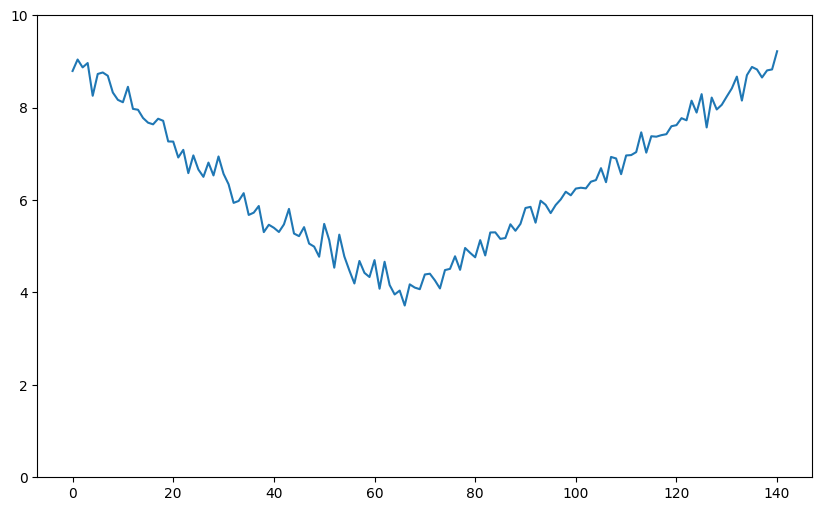

In [18]:
hrs_vs_thresh = pd.DataFrame({'thresh': thresh, 'y': y})

plt.plot(hrs_vs_thresh['thresh'], hrs_vs_thresh['y'])
plt.ylim(0, 10)
plt.show() 

Average prices for thresholds 0-140

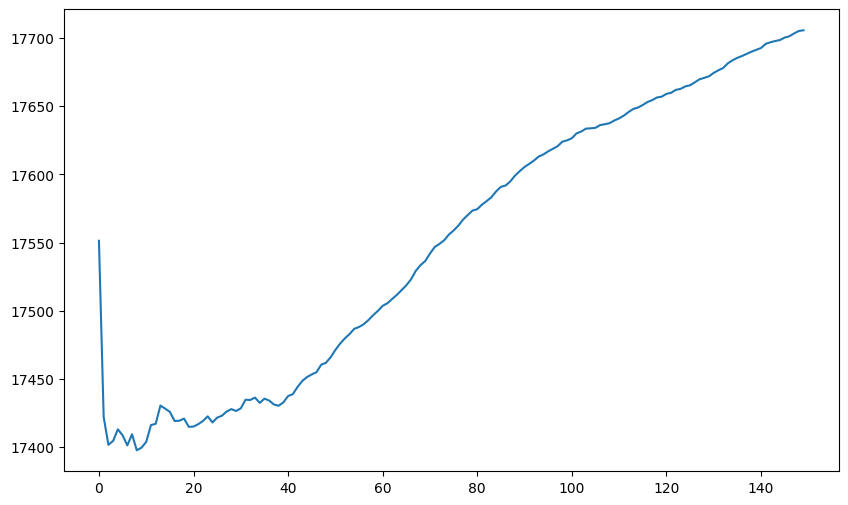

In [143]:
plt.plot(avgs) 